In [1]:
# =====================================================================================
# Directory Settings
# =====================================================================================
ROOT = '../input/liverpool-ion-switching/'
CLEAN_ROOT = '../input/data-without-drift/'
OUTPUT_DIR = '.'
MODEL_DIR1 = '../input/ion-stack1/'
MODEL_DIR2 = '../input/ion-stack3/'

In [2]:
class CFG:
    learning_rate=3.0e-3
    batch_size=32
    num_workers=6
    print_freq=1000
    test_freq=1
    start_epoch=0
    num_train_epochs=150
    warmup_steps=30
    max_grad_norm=1000
    gradient_accumulation_steps=1
    weight_decay=0.01
    dropout=0.3
    emb_size=100
    hidden_size=164
    nlayers=2
    nheads=10
    seq_len=5000
    total_cate_size=40
    seed=1225
    encoder='Wavenet'
    optimizer='Adam' #@param ['AdamW', 'Adam']
    target_size=11
    n_fold=4
    fold=[1, 3] #[0, 1, 2, 3]

In [3]:
# =====================================================================================
# Library
# =====================================================================================
import sys
import os
import gc
import time
from contextlib import contextmanager
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import random
import json

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn import preprocessing

from tqdm import tqdm, tqdm_notebook

import torch

import warnings
warnings.filterwarnings("ignore")

In [4]:
# =====================================================================================
# Utils
# =====================================================================================
def get_logger(filename=OUTPUT_DIR+'log'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


@contextmanager
def timer(name):
    t0 = time.time()
    logger.info(f'[{name}] start')
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')


def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def load_df(path, debug=False):
    # load df .csv or .pkl
    if path.split('.')[-1]=='csv':
        df = pd.read_csv(path)
        if debug:
            df = pd.read_csv(path, nrows=1000)
    elif path.split('.')[-1]=='pkl':
        df = pd.read_pickle(path)
    print(f"{path} shape / {df.shape} ")
    return df

In [5]:
# =====================================================================================
# General Settings
# =====================================================================================
df_path_dict = {'train': CLEAN_ROOT+'train_clean.csv',
                'test': CLEAN_ROOT+'test_clean.csv',
                'sample_submission': ROOT+'sample_submission.csv'}
ID = 'time'
TARGET = 'open_channels'
SEED = 42
seed_everything(seed=SEED)

In [6]:
# =====================================================================================
# Data Loading
# =====================================================================================
with timer('Data Loading'):
    X_train = load_df(path=df_path_dict['train'])
    X_test = load_df(path=df_path_dict['test'])
    submission = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv", dtype={'time':str})
    oof_lgb = pd.read_csv('../input/ion-oof/oof_lightgbm.csv').rename(columns={TARGET:'signal_lgb_oof'})
    pred_lgb = pd.read_csv('../input/ion-oof/predictions_lightgbm.csv').rename(columns={TARGET:'signal_lgb_oof'})
    oof_cat = pd.read_csv('../input/ion-oof/oof_catboost.csv').rename(columns={TARGET:'signal_cat_oof'})
    pred_cat = pd.read_csv('../input/ion-oof/predictions_catboost.csv').rename(columns={TARGET:'signal_cat_oof'})

    X_train = pd.concat([X_train, oof_lgb['signal_lgb_oof']], axis=1)
    X_test = pd.concat([X_test, pred_lgb['signal_lgb_oof']], axis=1)
    X_train = pd.concat([X_train, oof_cat['signal_cat_oof']], axis=1)
    X_test = pd.concat([X_test, pred_cat['signal_cat_oof']], axis=1)

[Data Loading] start


../input/data-without-drift/train_clean.csv shape / (5000000, 3) 
../input/data-without-drift/test_clean.csv shape / (2000000, 2) 


[Data Loading] done in 8 s


In [7]:
# =====================================================================================
# Preprocess
# =====================================================================================
X_train['batch'] = X_train.index // 500000
X_train['batch'] = X_train['batch'].astype(int)
X_test['batch'] = X_test.index // 500000
X_test['batch'] = X_test['batch'].astype(int)


def signal2cate(X_train, X_test=None, NUM_BINS=1000):
    signal_bins = np.linspace(X_train['signal'].min(), X_train['signal'].max(), NUM_BINS + 1)
    train_signal_dig = np.digitize(X_train['signal'], bins=signal_bins) - 1
    train_signal_dig = np.minimum(train_signal_dig, len(signal_bins) - 2)
    X_train['signal_cate'] = train_signal_dig
    if X_test is not None:
        test_signal_dig = np.digitize(X_test['signal'], bins=signal_bins) - 1
        test_signal_dig = np.minimum(test_signal_dig, len(signal_bins) - 2)
        X_test['signal_cate'] = test_signal_dig
        return  X_train, X_test
    return X_train

X_train, X_test = signal2cate(X_train, X_test, NUM_BINS=CFG.total_cate_size)


def add_num_features(X_train, X_test=None):
    max_signal = X_train['signal'].max()
    min_signal = X_train['signal'].min()
    X_train['signal_diff_max'] = max_signal - X_train['signal']
    X_train['signal_diff_min'] = min_signal - X_train['signal']
    if X_test is not None:
        X_test['signal_diff_max'] = max_signal - X_test['signal']
        X_test['signal_diff_min'] = min_signal - X_test['signal']
        return  X_train, X_test
    return X_train

X_train, X_test = add_num_features(X_train, X_test)


def calc_gradients(df):

    df['signal_gradient'] = np.gradient(df['signal'].values)

    return df

def preprocess_df(df):

    output = pd.DataFrame()

    for i in range(int(len(df)/500000)):
        tmp = df.loc[i * 500000: 500000*(i + 1) - 1].reset_index(drop=True)
        tmp = calc_gradients(tmp)
        output = pd.concat([output, tmp])

    return output.reset_index(drop=True)

X_train = preprocess_df(X_train)
X_test = preprocess_df(X_test)

In [8]:
# =====================================================================================
# Dataset
# =====================================================================================
from torch.utils.data import Dataset


class TrainDataset(Dataset):
    def __init__(self, df, sample_indices, cfg):
        self.df = df.copy()
        self.target = df[TARGET].values
        self.sample_indices = sample_indices
        self.cfg = cfg
        self.seq_len = self.cfg.seq_len
        self.cont_cols = self.cfg.cont_cols
        self.cate_cols = self.cfg.cate_cols
        self.cont_df = self.df[self.cont_cols]
        self.cate_df = self.df[self.cate_cols]

    def __getitem__(self, idx):
        indices = self.sample_indices[idx]
        seq_len = min(self.seq_len, len(indices))

        tmp_cont_x = torch.FloatTensor(self.cont_df.iloc[indices].values)
        cont_x = torch.FloatTensor(self.seq_len, len(self.cont_cols)).zero_()
        cont_x[-seq_len:] = tmp_cont_x[-seq_len:]

        tmp_cate_x = torch.LongTensor(self.cate_df.iloc[indices].values)
        cate_x = torch.LongTensor(self.seq_len, len(self.cate_cols)).zero_()
        cate_x[-seq_len:] = tmp_cate_x[-seq_len:]

        target = np.zeros(self.seq_len) - 1
        target[-seq_len:] = self.target[indices]

        return cate_x, cont_x, target

    def __len__(self):
        return len(self.sample_indices)
    

class TestDataset(Dataset):
    def __init__(self, df, sample_indices, cfg):
        self.df = df.copy()
        self.sample_indices = sample_indices
        self.cfg = cfg
        self.seq_len = self.cfg.seq_len
        self.cont_cols = self.cfg.cont_cols
        self.cate_cols = self.cfg.cate_cols
        self.cont_df = self.df[self.cont_cols]
        self.cate_df = self.df[self.cate_cols]

    def __getitem__(self, idx):
        indices = self.sample_indices[idx]
        seq_len = min(self.seq_len, len(indices))

        tmp_cont_x = torch.FloatTensor(self.cont_df.iloc[indices].values)
        cont_x = torch.FloatTensor(self.seq_len, len(self.cont_cols)).zero_()
        cont_x[-seq_len:] = tmp_cont_x[-seq_len:]

        tmp_cate_x = torch.LongTensor(self.cate_df.iloc[indices].values)
        cate_x = torch.LongTensor(self.seq_len, len(self.cate_cols)).zero_()
        cate_x[-seq_len:] = tmp_cate_x[-seq_len:]

        return cate_x, cont_x

    def __len__(self):
        return len(self.sample_indices)

In [9]:
# =====================================================================================
# Wavenet Model
# =====================================================================================
import torch.nn as nn
import torch.nn.functional as F


class wave_block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation):
        super().__init__()
        self.kernel_size = kernel_size
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=int((kernel_size + (kernel_size-1)*(dilation-1))/2), dilation=dilation)
        self.conv3 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=int((kernel_size + (kernel_size-1)*(dilation-1))/2), dilation=dilation)
        self.conv4 = nn.Conv1d(out_ch, out_ch, 1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.bn = nn.BatchNorm1d(out_ch)

    def forward(self, x):
        res_x = x
        tanh = self.tanh(self.conv2(x))
        sig = self.sigmoid(self.conv3(x))
        x = tanh.mul(sig)
        x = self.conv4(x)
        x = res_x + x
        return x


class Wavenet(nn.Module):
    def __init__(self, cfg, basic_block=wave_block):
        super().__init__()
        self.cfg = cfg
        self.basic_block = basic_block
        cont_col_size = len(cfg.cont_cols)
        cate_col_size = len(cfg.cate_cols)
        self.cate_emb = nn.Embedding(cfg.total_cate_size, cfg.emb_size, padding_idx=0)
        #self.cate_proj = nn.Sequential(
        #    nn.Linear(cfg.emb_size*cate_col_size, cfg.hidden_size//2),
        #    nn.LayerNorm(cfg.hidden_size//2),
        #)
        self.layer1 = self._make_layers(cont_col_size, cfg.hidden_size//16, 3, 12)
        self.layer2 = self._make_layers(cfg.hidden_size//16, cfg.hidden_size//8, 3, 8)
        self.layer3 = self._make_layers(cfg.hidden_size//8, cfg.hidden_size//4, 3, 4)
        self.layer4 = self._make_layers(cfg.hidden_size//4, cfg.hidden_size//2, 3, 1)
        self.gru = nn.GRU(input_size=cfg.emb_size*cate_col_size+cont_col_size, hidden_size=cfg.hidden_size//4, num_layers=cfg.nlayers,
                          bidirectional=True, batch_first=True, dropout=cfg.dropout)
        def get_reg():
            return nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.LayerNorm(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.target_size),
        )
        self.fc = get_reg()

    def _make_layers(self, in_ch, out_ch, kernel_size, n):
        dilation_rates = [2 ** i for i in range(n)]
        layers = [nn.Conv1d(in_ch, out_ch, 1)]
        for dilation in dilation_rates:
            layers.append(self.basic_block(out_ch, out_ch, kernel_size, dilation))
        return nn.Sequential(*layers)

    def forward(self, cate_x, cont_x):
        batch_size = cate_x.size(0)
        # RNN
        cate_emb = self.cate_emb(cate_x).view(batch_size, self.cfg.seq_len, -1)
        seq_emb = torch.cat((cate_emb, cont_x), 2)
        h_gru, _ = self.gru(seq_emb)
        # CNN
        cont_x = cont_x.permute(0, 2, 1)
        cont_x = self.layer1(cont_x)
        cont_x = self.layer2(cont_x)
        cont_x = self.layer3(cont_x)
        cont_x = self.layer4(cont_x)
        # CNN & RNN
        x = torch.cat((cont_x, h_gru.permute(0, 2, 1)), 1).permute(0, 2, 1)
        # fc
        x = self.fc(x)
        return x

In [10]:
# =====================================================================================
# Get Sample function
# =====================================================================================
def tta_group(X_train):
    tmp = X_train[CFG.seq_len//2:len(X_train)-CFG.seq_len//2].reset_index(drop=True)
    tmp['tta_group'] = tmp.index // CFG.seq_len
    tmp['tta_group'] = tmp['tta_group'] + tmp['group'].nunique()
    X_train = pd.concat([X_train[:CFG.seq_len//2], 
                         tmp, 
                         X_train[len(X_train)-CFG.seq_len//2:]]).reset_index(drop=True).fillna(-1)
    return X_train


def get_sample_indices(df):
    sample_indices = []
    group_indices = []
    df_groups = df.groupby('group').groups
    tta_df_groups = df[df['tta_group']>=0].groupby('tta_group').groups
    for group_idx, indices in enumerate(df_groups.values()):
        sample_indices.append(indices.values)
        group_indices.append(group_idx)
    for group_idx, indices in enumerate(tta_df_groups.values()):
        sample_indices.append(indices.values)
        group_indices.append(group_idx+len(df_groups))
    return np.array(sample_indices), group_indices

In [11]:
# =====================================================================================
# validate function
# =====================================================================================
from sklearn.metrics import f1_score


def validate(valid_loader, model, device):

    # switch to evaluation mode
    model.eval()
    val_preds, val_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
    
    tk0 = tqdm(enumerate(valid_loader), total=len(valid_loader))

    for step, (cate_x, cont_x, y) in tk0:

        cate_x, cont_x, y = cate_x.to(device), cont_x.to(device), y.to(device)

        # compute loss
        with torch.no_grad():
            pred = model(cate_x, cont_x)

            # record loss
            pred_ = pred.view(-1, pred.shape[-1])
            y_ = y.view(-1)

        # record accuracy
        val_true = torch.cat([val_true, y_.long()], 0)
        val_preds = torch.cat([val_preds, pred_], 0)

    # scoring
    predictions = val_preds.cpu().detach().numpy().argmax(1)
    groundtruth = val_true.cpu().detach().numpy()
    score = f1_score(predictions, groundtruth, labels=list(range(11)), average='macro')
    logger.info(f'score: {score}')

    return predictions, groundtruth

In [12]:
# =====================================================================================
# Inference function
# =====================================================================================
def inference(test_loader, model, device):
    
    # switch to evaluation mode
    model.eval()
    probs = torch.Tensor([]).to(device)
    
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, (cate_x, cont_x) in tk0:      
        
        cate_x, cont_x = cate_x.to(device), cont_x.to(device)
        
        with torch.no_grad():        
            pred = model(cate_x, cont_x)
            pred_ = pred.view(-1, pred.shape[-1])
        
        probs = torch.cat([probs, pred_], 0)

    probs = probs.cpu().detach().numpy()
    
    return probs

In [13]:
# =====================================================================================
# CV
# =====================================================================================
import copy
from torch.utils.data import DataLoader


def check_CV(fold, trn_idx, val_idx, model_path):
    
    # =====================================================================================
    # Settings
    # =====================================================================================
    cate_cols = [c for c in X_train.columns if c.find('cate')>=0]
    if fold==1:
        cont_cols = ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
    else:
        cont_cols = ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
    logger.info(f'cont_cols: {cont_cols}')
    logger.info(f'cate_cols: {cate_cols}')
    CFG.cont_cols = cont_cols
    CFG.cate_cols = cate_cols
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f'device: {device}')

    # =====================================================================================
    # Prepare loader
    # =====================================================================================
    #train_samples = sample_indices[trn_idx]
    valid_samples = sample_indices[val_idx]

    #train_db = TrainDataset(X_train, train_samples, CFG)
    valid_db = TrainDataset(X_train, valid_samples, CFG)

    #train_loader = DataLoader(train_db, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
    valid_loader = DataLoader(valid_db, batch_size=CFG.batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # =====================================================================================
    # Prepare model
    # =====================================================================================
    model = Wavenet(CFG)
    checkpoint = torch.load(model_path, map_location=device)
    logger.info(checkpoint['log'].sort_values(['VALID_SCORE']).tail(1))
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    
    # =====================================================================================
    # CV
    # =====================================================================================
    predictions, groundtruth = validate(valid_loader, model, device)
    
    return predictions, groundtruth

In [14]:
"""
X_train['group'] = X_train.index // CFG.seq_len
X_train = tta_group(X_train)
X_train['tta_group'] = X_train['tta_group'].astype(int)
X_train['split_group'] = X_train.index // (CFG.seq_len*2)
sample_indices, group_indices = get_sample_indices(X_train)
print(len(group_indices))
print(len(set(group_indices)))
group_map = dict(X_train[['group', 'split_group']].values.tolist())
tta_group_map = dict(X_train[['tta_group', 'split_group']].values.tolist())
group_map.update(tta_group_map)
group_indices = [group_map[i] for i in group_indices]
print(len(group_indices))
print(len(set(group_indices)))
folds = pd.read_csv('../input/ion-folds/folds.csv')
folds_map = dict(folds[['split_group', 'fold']].values.tolist())
group_indices = [folds_map[i] for i in group_indices]
skf = GroupKFold(n_splits=CFG.n_fold)
splits = [x for x in skf.split(sample_indices, None, group_indices)]
predictions, groundtruth = [], []
for fold, (trn_idx, val_idx) in enumerate(splits):
    if fold in CFG.fold:
        with timer(f'##### Running Fold: {fold} #####'):
            if fold==1:
                model_path = MODEL_DIR1 + f'f-{fold}_b-{CFG.batch_size}_a-{CFG.encoder}_e-{CFG.emb_size}_h-{CFG.hidden_size}_'\
                                + f'd-{CFG.dropout}_l-{CFG.nlayers}_hd-{CFG.nheads}_s-{CFG.seed}_len-{CFG.seq_len}.pt'
            else:
                model_path = MODEL_DIR2 + f'f-{fold}_b-{CFG.batch_size}_a-{CFG.encoder}_e-{CFG.emb_size}_h-{CFG.hidden_size}_'\
                                + f'd-{CFG.dropout}_l-{CFG.nlayers}_hd-{CFG.nheads}_s-{CFG.seed}_len-{CFG.seq_len}.pt'
            _predictions, _groundtruth = check_CV(fold, trn_idx, val_idx, model_path)
            predictions.append(_predictions)
            groundtruth.append(_groundtruth)
predictions = np.concatenate(predictions)
groundtruth = np.concatenate(groundtruth)
score = f1_score(predictions, groundtruth, labels=list(range(11)), average='macro')
logger.info(f'##### CV Score: {score} #####')
"""

"\nX_train['group'] = X_train.index // CFG.seq_len\nX_train = tta_group(X_train)\nX_train['tta_group'] = X_train['tta_group'].astype(int)\nX_train['split_group'] = X_train.index // (CFG.seq_len*2)\nsample_indices, group_indices = get_sample_indices(X_train)\nprint(len(group_indices))\nprint(len(set(group_indices)))\ngroup_map = dict(X_train[['group', 'split_group']].values.tolist())\ntta_group_map = dict(X_train[['tta_group', 'split_group']].values.tolist())\ngroup_map.update(tta_group_map)\ngroup_indices = [group_map[i] for i in group_indices]\nprint(len(group_indices))\nprint(len(set(group_indices)))\nfolds = pd.read_csv('../input/ion-folds/folds.csv')\nfolds_map = dict(folds[['split_group', 'fold']].values.tolist())\ngroup_indices = [folds_map[i] for i in group_indices]\nskf = GroupKFold(n_splits=CFG.n_fold)\nsplits = [x for x in skf.split(sample_indices, None, group_indices)]\npredictions, groundtruth = [], []\nfor fold, (trn_idx, val_idx) in enumerate(splits):\n    if fold in CFG.

# Prepare

In [15]:
total_probs = np.zeros((len(X_test), 11))
total_probs.shape

(2000000, 11)

In [16]:
# =====================================================================================
# Get Sample function
# =====================================================================================
def get_sample_indices(df):
    sample_indices = []
    group_indices = []
    df_groups = df.groupby('group').groups
    for group_idx, indices in enumerate(df_groups.values()):
        sample_indices.append(indices.values)
        group_indices.append(group_idx)
    return sample_indices, group_indices

In [17]:
# =====================================================================================
# Inference
# =====================================================================================
import copy
from torch.utils.data import DataLoader


def predict(model_path, X_test, test_samples):
    
    # =====================================================================================
    # Settings
    # =====================================================================================
    cate_cols = [c for c in X_train.columns if c.find('cate')>=0]
    if fold==1:
        cont_cols = ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
    else:
        cont_cols = ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
    logger.info(f'cont_cols: {cont_cols}')
    logger.info(f'cate_cols: {cate_cols}')
    CFG.cont_cols = cont_cols
    CFG.cate_cols = cate_cols
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f'device: {device}')

    # =====================================================================================
    # Prepare loader
    # =====================================================================================
    test_db = TestDataset(X_test, test_samples, CFG)
    test_loader = DataLoader(test_db, batch_size=CFG.batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # =====================================================================================
    # Prepare model
    # =====================================================================================
    model = Wavenet(CFG)
    checkpoint = torch.load(model_path, map_location=device)
    logger.info(checkpoint['log'].sort_values(['VALID_SCORE']).tail(1))
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    
    # =====================================================================================
    # Inference
    # =====================================================================================
    prob = inference(test_loader, model, device)
    
    return prob

## normal

In [18]:
X_test['group'] = X_test.index // CFG.seq_len
test_samples, _ = get_sample_indices(X_test)

probs = []
for fold in CFG.fold:
    if fold==1:
        model_path = MODEL_DIR1 + f'f-{fold}_b-{CFG.batch_size}_a-{CFG.encoder}_e-{CFG.emb_size}_h-{CFG.hidden_size}_'\
                                + f'd-{CFG.dropout}_l-{CFG.nlayers}_hd-{CFG.nheads}_s-{CFG.seed}_len-{CFG.seq_len}.pt'
    else:
        model_path = MODEL_DIR2 + f'f-{fold}_b-{CFG.batch_size}_a-{CFG.encoder}_e-{CFG.emb_size}_h-{CFG.hidden_size}_'\
                                + f'd-{CFG.dropout}_l-{CFG.nlayers}_hd-{CFG.nheads}_s-{CFG.seed}_len-{CFG.seq_len}.pt'
    prob = predict(model_path, X_test, test_samples)
    probs.append(prob)
probs = np.mean(probs, axis=0)
total_probs += probs

cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:11<00:00,  1.18it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


## TTA

In [19]:
for w in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]:
    
    print(f'w: {w}')
    tmp = pd.DataFrame()
    for i in range(int(len(X_test)/500000)):
        _tmp = X_test[i*500000+w:(i+1)*500000-(CFG.seq_len-w)]
        tmp = pd.concat([tmp, _tmp])
    idxes = tmp.index.tolist()
    tmp = tmp.reset_index(drop=True)
    print(tmp.shape)

    tmp['group'] = tmp.index // CFG.seq_len
    test_samples, _ = get_sample_indices(tmp)

    probs = []
    for fold in CFG.fold:
        if fold==1:
            model_path = MODEL_DIR1 + f'f-{fold}_b-{CFG.batch_size}_a-{CFG.encoder}_e-{CFG.emb_size}_h-{CFG.hidden_size}_'\
                                    + f'd-{CFG.dropout}_l-{CFG.nlayers}_hd-{CFG.nheads}_s-{CFG.seed}_len-{CFG.seq_len}.pt'
        else:
            model_path = MODEL_DIR2 + f'f-{fold}_b-{CFG.batch_size}_a-{CFG.encoder}_e-{CFG.emb_size}_h-{CFG.hidden_size}_'\
                                    + f'd-{CFG.dropout}_l-{CFG.nlayers}_hd-{CFG.nheads}_s-{CFG.seed}_len-{CFG.seq_len}.pt'
        prob = predict(model_path, tmp, test_samples)
        probs.append(prob)
    tta_probs = np.zeros((len(X_test), 11))
    tta_probs[idxes] = np.mean(probs, axis=0)
    total_probs += tta_probs

w: 500


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


w: 1000


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


w: 1500


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:11<00:00,  1.17it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


w: 2000


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


w: 2500


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:11<00:00,  1.16it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


w: 3000


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:10<00:00,  1.19it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


w: 3500


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:11<00:00,  1.17it/s]


w: 4000


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:11<00:00,  1.16it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


w: 4500


cont_cols: ['signal', 'signal_lgb_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda


(1980000, 10)


  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0    87  0.001308    0.041772     0.940986    0.040835     0.942253
100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
cont_cols: ['signal', 'signal_lgb_oof', 'signal_cat_oof', 'signal_diff_max', 'signal_diff_min', 'signal_gradient']
cate_cols: ['signal_cate']
device: cuda
  EPOCH        LR  TRAIN_LOSS  TRAIN_SCORE  VALID_LOSS  VALID_SCORE
0   121  0.000307    0.040285     0.942068    0.041028     0.942518
100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


## AVG

In [20]:
predictions = total_probs.argmax(1)
predictions.shape

(2000000,)

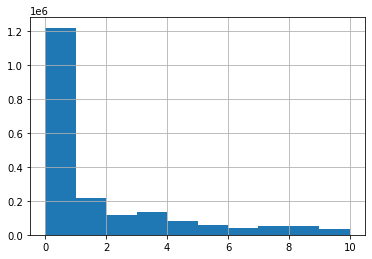

In [21]:
sub = submission.copy()
sub[TARGET] = predictions
sub[TARGET] = sub[TARGET].astype(int)
sub[TARGET].hist()

In [22]:
sub.to_csv('submission.csv', index=False)